<a href="https://colab.research.google.com/github/brianellis1997/Sarcasm_Detection/blob/Lindsey/DS_440_Test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sarcasm Detection using NLP Techniques
### Team 2: Brian Ellis, Lindsey Rich, Elena Kern

## Load Libraries and Dataset

In [1]:
import pandas as pd
import torch
from wordcloud import WordCloud
import matplotlib.pyplot as plt

#test comment

In [2]:
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
import torch.optim as optim
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

In [3]:
!git clone https://github.com/brianellis1997/Sarcasm_Detection.git

Cloning into 'Sarcasm_Detection'...
remote: Enumerating objects: 62, done.
remote: Counting objects: 100% (62/62), done.
remote: Compressing objects: 100% (62/62), done.
remote: Total 62 (delta 30), reused 3 (delta 0), pack-reused 0
Receiving objects: 100% (62/62), 650.14 KiB | 2.60 MiB/s, done.
Resolving deltas: 100% (30/30), done.


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
train_bal = pd.read_csv('/content/drive/MyDrive/Sarcasm_Data/train-balanced-sarcasm.csv')   # Make sure path is correct in your google drive
train_bal.head()

,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment
0,0,NC and NH.,Trumpbart,politics,2,-1,-1,2016-10,2016-10-16 23:55:23,"Yeah, I get that argument. At this point, I'd ..."
1,0,You do know west teams play against west teams...,Shbshb906,nba,-4,-1,-1,2016-11,2016-11-01 00:24:10,The blazers and Mavericks (The wests 5 and 6 s...
2,0,"They were underdogs earlier today, but since G...",Creepeth,nfl,3,3,0,2016-09,2016-09-22 21:45:37,They're favored to win.
3,0,"This meme isn't funny none of the ""new york ni...",icebrotha,BlackPeopleTwitter,-8,-1,-1,2016-10,2016-10-18 21:03:47,deadass don't kill my buzz
4,0,I could use one of those tools.,cush2push,MaddenUltimateTeam,6,-1,-1,2016-12,2016-12-30 17:00:13,Yep can confirm I saw the tool they use for th...


In [6]:
train_bal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1010826 entries, 0 to 1010825
Data columns (total 10 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   label           1010826 non-null  int64 
 1   comment         1010773 non-null  object
 2   author          1010826 non-null  object
 3   subreddit       1010826 non-null  object
 4   score           1010826 non-null  int64 
 5   ups             1010826 non-null  int64 
 6   downs           1010826 non-null  int64 
 7   date            1010826 non-null  object
 8   created_utc     1010826 non-null  object
 9   parent_comment  1010826 non-null  object
dtypes: int64(4), object(6)
memory usage: 77.1+ MB


In [7]:
train_bal['label'].value_counts()

0    505413
1    505413
Name: label, dtype: int64

We can see our dataset is balanced.

In [8]:
train_bal['comment'] = train_bal['comment'].astype('str')
train_bal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1010826 entries, 0 to 1010825
Data columns (total 10 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   label           1010826 non-null  int64 
 1   comment         1010826 non-null  object
 2   author          1010826 non-null  object
 3   subreddit       1010826 non-null  object
 4   score           1010826 non-null  int64 
 5   ups             1010826 non-null  int64 
 6   downs           1010826 non-null  int64 
 7   date            1010826 non-null  object
 8   created_utc     1010826 non-null  object
 9   parent_comment  1010826 non-null  object
dtypes: int64(4), object(6)
memory usage: 77.1+ MB


In [9]:
train_bal[:20]['comment']

0                                            NC and NH.
1     You do know west teams play against west teams...
2     They were underdogs earlier today, but since G...
3     This meme isn't funny none of the "new york ni...
4                       I could use one of those tools.
5     I don't pay attention to her, but as long as s...
6         Trick or treating in general is just weird...
7                       Blade Mastery+Masamune or GTFO!
8     You don't have to, you have a good build, buy ...
9                     I would love to see him at lolla.
10    I think a significant amount would be against ...
11                       Damn I was hoping God was real
12                                 They have an agenda.
13                                          Great idea!
14    Ayy bb wassup, it makes a bit more sense in co...
15                                        what the fuck
16                                               noted.
17    because it's what really bothers him... an

## EDA

In [10]:
# Separating sarcastic vs non sarcastic comments
sarcastic_com = train_bal[train_bal['label'] == 1]
non_sarcastic_com = train_bal[train_bal['label'] == 0]

In [11]:
# # WordCloud for sarcastic comments
# wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(sarcastic_com['comment'].values.ravel()))

# # Display the generated word cloud using matplotlib
# plt.figure(figsize=(10, 5))
# plt.imshow(wordcloud, interpolation='bilinear')
# plt.axis('off')
# plt.show()

In [12]:
# # WordCloud for non-sarcastic comments
# wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(non_sarcastic_com['comment'].values.ravel()))

# # Display the generated word cloud using matplotlib
# plt.figure(figsize=(10, 5))
# plt.imshow(wordcloud, interpolation='bilinear')
# plt.axis('off')
# plt.show()

# Visualizing Sarcastic Comments by Subreddit

In [13]:
subreddit_count = sarcastic_com['subreddit'].value_counts()

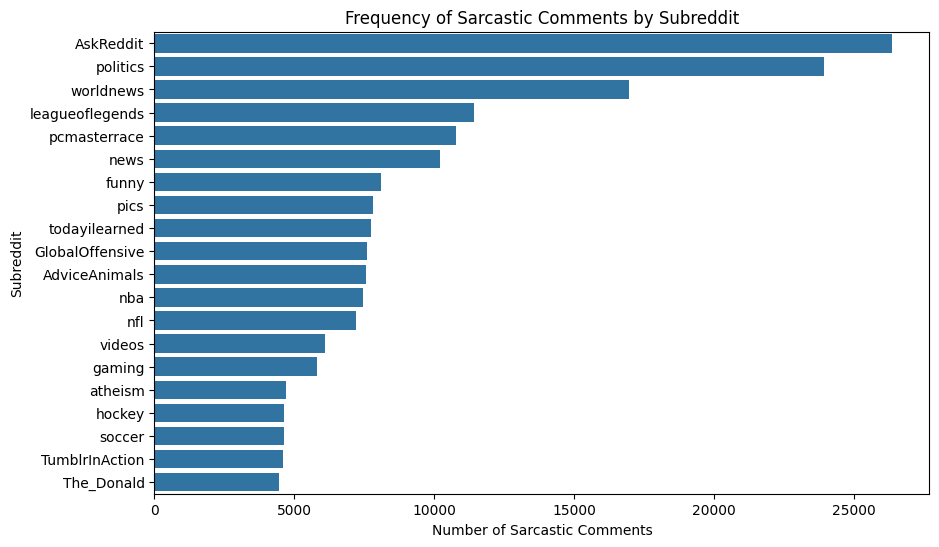

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
top = subreddit_count.head(20)
plt.figure(figsize=(10, 6))
sns.barplot(x=top.values, y=top.index)
plt.xlabel('Number of Sarcastic Comments')
plt.ylabel('Subreddit')
plt.title('Frequency of Sarcastic Comments by Subreddit')
plt.show()


In [15]:
import nltk
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import *
nltk.download('punkt')
nltk.download('stopwords')

import string

import gensim
from gensim.models.phrases import Phraser, Phrases
from gensim.models.word2vec import Word2Vec

import spacy # for a lemmatization example

from sklearn.manifold import TSNE

import pandas as pd
from bokeh.io import output_notebook, output_file
from bokeh.plotting import show, figure

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [16]:
comments = train_bal['comment']

In [17]:
comments

0                                                 NC and NH.
1          You do know west teams play against west teams...
2          They were underdogs earlier today, but since G...
3          This meme isn't funny none of the "new york ni...
4                            I could use one of those tools.
                                 ...                        
1010821    I'm sure that Iran and N. Korea have the techn...
1010822                   whatever you do, don't vote green!
1010823    Perhaps this is an atheist conspiracy to make ...
1010824    The Slavs got their own country - it is called...
1010825    values, as in capitalism .. there is good mone...
Name: comment, Length: 1010826, dtype: object

In [18]:
comments.dropna(inplace=True)

In [19]:
!pip install dask[delayed]

In [20]:
import dask.dataframe as dd
from dask import delayed

In [21]:
comment_test = comments.head(10000)

In [22]:
#  Replace this?
def batch_tokenize(texts, batch_size=50000):
    tokenized_texts = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        tokenized_batch = [word_tokenize(text) for text in batch]
        tokenized_texts.extend(tokenized_batch)
    return tokenized_texts

tokenized_comments = batch_tokenize(comments.tolist())

In [23]:
len(tokenized_comments)

1010826

In [24]:
phrases = Phrases(tokenized_comments)

In [26]:
bigram = Phraser(phrases)

In [29]:
bigram.phrasegrams

{'more_than': 15.716730362912466,
 'earlier_today': 97.54381354131893,
 'none_of': 13.722374640799995,
 'new_york': 257.48770471767295,
 "do_n't": 12.087144114385973,
 'pay_attention': 78.43528176225679,
 'as_long': 14.295867368262096,
 'long_as': 22.687197188348147,
 'in_general': 10.094824562311834,
 'or_GTFO': 43.58683606062638,
 'significant_amount': 78.15981810665564,
 'tax_dollars': 225.94302032653218,
 'was_hoping': 13.380560989640756,
 'an_agenda': 11.796624209438384,
 'Great_idea': 26.313272206303726,
 "they_'re": 10.092079144398877,
 'This_guy': 10.018783796951581,
 'human_beings': 829.7288460038118,
 'according_to': 11.843485674302368,
 'put_together': 12.221554453659765,
 'was_born': 13.358456538666681,
 '20_mins': 134.73333903426257,
 'fell_asleep': 749.0172550400564,
 'Mountain_Dew': 14656.48062015504,
 'Funny_how': 28.003625034976217,
 'go_wrong': 11.633722817353153,
 'as_well': 22.45076497941667,
 'totally_unreasonable': 11.779999543093547,
 'war_crimes': 154.0807622682

In [51]:
bigram_comments = [bigram[comment] for comment in tokenized_comments]


In [52]:
# Adjust parameters as needed
size = 150
window = 7
min_count = 15
workers = 4
sg = 1
negative = 5
epochs = 7


model = Word2Vec(bigram_comments, vector_size=size, window=window, min_count=min_count, workers=workers)

model.save("word2vec.model")


In [59]:
vector = model.wv['blob']

In [56]:
similar_words = model.wv.most_similar('!')
similar_words

[('.', 0.538338840007782),
 ('glorious', 0.4584600627422333),
 ('ruining', 0.42585262656211853),
 ('eh_?', 0.4213748276233673),
 ('you_uncultured', 0.4004848301410675),
 ('huh_?', 0.39263787865638733),
 ('amirite_?', 0.39133378863334656),
 ('commie', 0.36757874488830566),
 ('Make_America', 0.3658772110939026),
 ('bringing', 0.35828104615211487)]

# Start LSTM architecture with these initial embeddings before BERT


# Need to create embeddings matrix for LSTM


In [57]:
model = Word2Vec.load("/content/word2vec.model")
